# Case Study - Differential Equation Modeling

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Define starting values:

In [2]:
def starting_values():
    # Total population, N.
    N = 10000
    # Initial number of infected, exposed and recovered individuals, I0 and R0.
    E0, I0, R0 = 5, 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - E0 - I0 - R0

    num_days = 100
    
    return N, S0, E0, I0, R0, num_days


N, S0, E0, I0, R0, num_days = starting_values()

# A grid of time points (in days)
t = np.linspace(0, num_days, num_days+1)

### Define disease parameters:

In [3]:
# force of infection (?):
beta = 10 ** -4

# average duration of latency period:
len_latency = 4

# average duration of infectious period:
len_infectious = 10

# affected age range:
age_range = (3,6)

### Compute model parameters:

In [4]:
# rate of transition from E to I
delta = 1 / len_latency

# rate of transition from I to R (rate of recovery)
gamma = 1 / len_infectious

# demography (rate of individuals entering and and leaving the specified age interval)
mu = 1 / (365 * (age_range[1]-age_range[0]+1))

## Construction of differential equations:

In [5]:
# The SEIR model differential equations.
def deriv(y, t, N, beta, gamma, delta, mu):
    S, E, I, R = y
    
    # Susceptibles:
    dSdt = -beta * S * I + mu * (N - S)
    
    # Exposed:
    dEdt = beta * S * I - delta * E - mu * E
    
    # Infectious:
    dIdt = delta * E - gamma * I - mu * I
    
    # Recovered:
    dRdt = gamma * I - mu * R
    
    return dSdt, dEdt, dIdt, dRdt

### Run Model:

In [18]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, mu))
S, E, I, R = ret.T

### Plot Results:

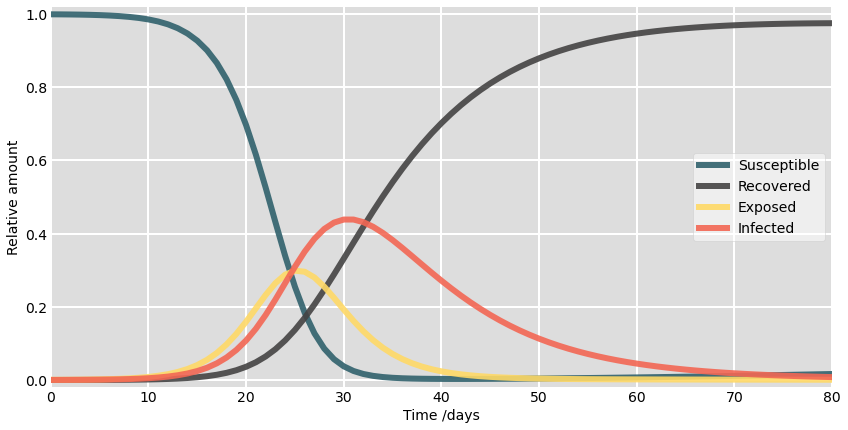

In [19]:
##### Plot the data on three separate curves for S(t), I(t) and R(t)
lw = 6
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, color='#30616C', alpha=0.9, lw=lw, label='Susceptible')
ax.plot(t, R/N, color='#444343', alpha=0.9, lw=lw, label='Recovered')
ax.plot(t, E/N, color='#FFD966', alpha=0.9, lw=lw, label='Exposed')
ax.plot(t, I/N, color='#F36754', alpha=0.9, lw=lw, label='Infected')
ax.set_xlabel('Time /days')
ax.set_ylabel('Relative amount')
ax.set_ylim(-0.02,1.02)
ax.set_xlim(0,np.max(t)*0.8)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.rcParams["figure.figsize"] = (14,7)
plt.rc('font', **font)

plt.show()

### Plot only infection numbers:

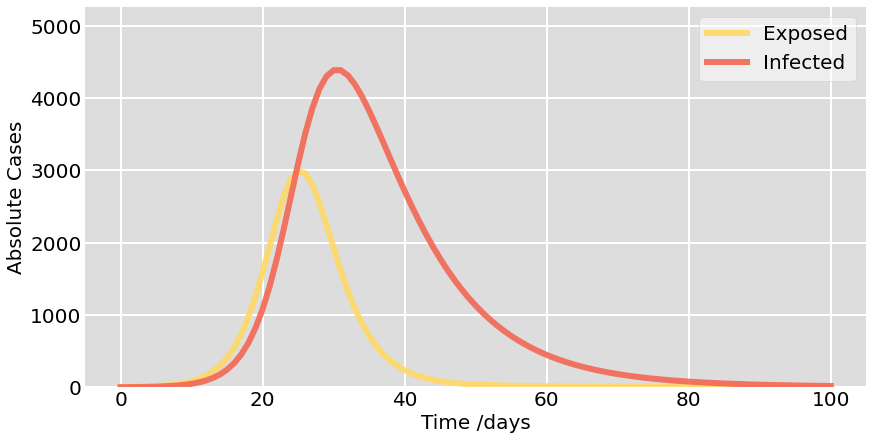

In [20]:
##### Plot the data on the curves for E(t) and I(t)
lw = 6
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, E, color='#FFD966', alpha=0.9, lw=lw, label='Exposed')
ax.plot(t, I, color='#F36754', alpha=0.9, lw=lw, label='Infected')
ax.set_xlabel('Time /days')
ax.set_ylabel('Absolute Cases')
ax.set_ylim(0,np.amax(I)*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.rcParams["figure.figsize"] = (14,7)
plt.rc('font', **font)

plt.show()

## Intervention modeling

   ### Containment measures:

The following measures are introduced:
<ol>
    <li> Hygiene measures (day t=14)
    <li> Smaller groups (day t=21)
    <li> Kindergarten closures (day t=28)
</ol>

All three lead to the following reductions in contact rates and probabilities of infection:

In [9]:
# given:
def get_r0(t):
    if t < 14:
        return 10 # base case
    elif t < 21:
        return 6 # hygiene measures
    elif t < 28:
        return 3 # smaller groups
    else:
        return 1.5 # kindergarten closures
    
# compute beta based on r0:
def get_beta(t):
    # get values:
    r0 = get_r0(t)
    
    # compute beta:
    beta = r0 * gamma / N
    
    return beta    

Vaccinations:

In [10]:
# get number of vaccinations
def get_vaccinations(t):
    
    if t < 28:
        return 0 # base case (no vaccinations available until week 5)
    elif t < 35:
        return 20 # first vaccine doses available
    else:
        return 100 # larger doses available
    
    
# Percentage of parents that are willing to vacinate their children:
vaccination_readiness = 0.8

### Advanced Model:

In [11]:
# The SEIR model differential equations.
def deriv_advanced_model(y, t, N, gamma, delta, mu):
    S, E, I, R, I_total, V = y
    
    beta = get_beta(t)
    new_vaccinations = min(get_vaccinations(t), vaccination_readiness*S)
    
    # Susceptibles:
    dSdt = -beta * S * I + mu * (N - S) - new_vaccinations
    
    # Exposed:
    dEdt = beta * S * I - delta * E - mu * E
    
    # Infectious:
    dIdt = delta * E - gamma * I - mu * I
    
    # Recovered:
    dRdt = gamma * I - mu * R
    
    # Vaccinated:
    dVdt = new_vaccinations - mu * V
    
    
    ### New:
    # Total_Infections:
    dI_totdt = delta * E
    
    return dSdt, dEdt, dIdt, dRdt, dI_totdt, dVdt

In [12]:
# Initial conditions vector
I_total0 = 0
V0 = 0

y0 = S0, E0, I0, R0, I_total0, V0
# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv_advanced_model, y0, t, args=(N, gamma, delta, mu))
S, E, I, R, dI_tot, V = ret.T

In [13]:
# Derive delta in total number of infectious individuals:
daily_new_infections = np.diff(dI_tot)

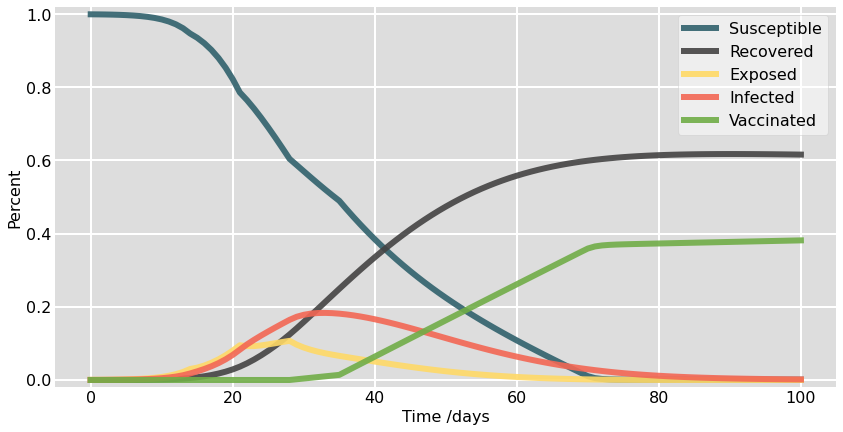

In [14]:
##### Plot the data on three separate curves for S(t), I(t) and R(t)
lw = 6
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, color='#30616C', alpha=0.9, lw=lw, label='Susceptible')
ax.plot(t, R/N, color='#444343', alpha=0.9, lw=lw, label='Recovered')
ax.plot(t, E/N, color='#FFD966', alpha=0.9, lw=lw, label='Exposed')
ax.plot(t, I/N, color='#F36754', alpha=0.9, lw=lw, label='Infected')
ax.plot(t, V/N, color='#70AD47', alpha=0.9, lw=lw, label='Vaccinated')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percent')
ax.set_ylim(-0.02,1.02)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.rcParams["figure.figsize"] = (12,8)
plt.rc('font', **font)

plt.show()

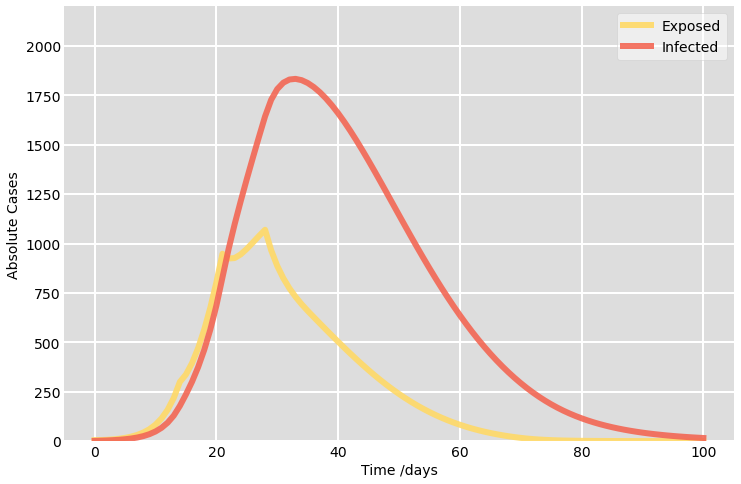

In [15]:
##### Plot the data on the curves for E(t) and I(t)
lw = 6
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, E, color='#FFD966', alpha=0.9, lw=lw, label='Exposed')
ax.plot(t, I, color='#F36754', alpha=0.9, lw=lw, label='Infected')
ax.set_xlabel('Time /days')
ax.set_ylabel('Absolute Cases')
ax.set_ylim(-1,np.amax(I)*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.rcParams["figure.figsize"] = (14,7)
plt.rc('font', **font)

plt.show()

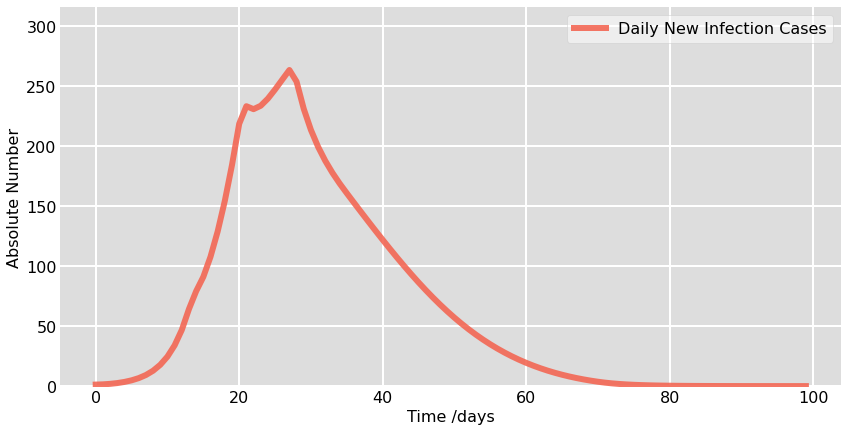

In [21]:
##### Plot daily cases
lw = 6
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t[:-1], daily_new_infections, color='#F36754', alpha=0.9, lw=lw, label='Daily New Infection Cases')
ax.set_xlabel('Time /days')
ax.set_ylabel('Absolute Number')
ax.set_ylim(-1,np.amax(daily_new_infections)* 1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
plt.rcParams["figure.figsize"] = (14,7)
plt.rc('font', **font)

plt.show()

In [17]:
np.round(daily_new_infections[0:15])

array([ 1.,  1.,  2.,  3.,  3.,  5.,  7.,  9., 13., 18., 25., 34., 47.,
       64., 79.])